In [69]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import dc_stat_think as dc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os


In [70]:
def select_cond_neurons(neurons, ifr_all, cond):
    if cond == 'acute_cit':
        good_recordings=[1,3,5,6,8,9,10]
    elif cond == 'acute_sal':
        good_recordings = [11, 12, 14, 15]
    elif cond == 'sert_gq':
        good_recordings = [29, 30, 34, 35, 36, 38]
    elif cond == 'sert_mcherry':
        good_recordings = [31, 32, 33]
    elif cond == 'vgat_gq':
        good_recordings = [42, 43, 44]
    elif cond == 'vgat_mcherry':
        good_recordings = [40, 41]
        
    ids = neurons[neurons['recording_id'].isin(good_recordings)]['neuron_id'].values
    ids = list(map(str, ids))
    return ifr_all.loc[:, ifr_all.columns.isin(ids)]


def select_relovant_time_period(df, time_period=960, exp_start=3600):
    lower = exp_start - time_period
    upper = exp_start + time_period
    return df.iloc[lower:upper, :]


def firing_rate_cutoff(df, mfr_cut_off=0.9, time_cuttoff=480):
    return df.loc[:, df.columns[(df.iloc[:time_cuttoff]>mfr_cut_off).all()]]


def drug_analysis_filter(neurons, ifr_all, cond, time_period=960, 
                         exp_start=3600, mfr_cutoff=0.9):
    df = select_cond_neurons(neurons, ifr_all, cond).fillna(0)
    df = select_relovant_time_period(df, time_period, exp_start)
    df = firing_rate_cutoff(df, mfr_cutoff, time_period)
    return df


def format_for_analysis(df, rs=10):
    ind = pd.timedelta_range(start=0, periods=len(df), freq='s')
    df.index = ind
    df = df.resample(f'{rs}S').mean()
    return df

In [71]:
def permutation_test(col, time, method='two tailed'):
    method = method.lower()
    
    a = col.iloc[:time].values.flatten()
    b = col.iloc[time:time+time].values.flatten()
    
    reps = dc.draw_perm_reps(data_1=a, data_2=b, func=dc.diff_of_means, size=5000)
    emp = dc.diff_of_means(a, b)
    
    if method.lower() == 'two tailed':
        emp =  np.absolute(emp)
        reps = np.absolute(reps)
        p = np.sum(reps >= emp)
        
    elif method == 'decrease':
        # emp will be a positive
        p =  np.sum(reps >= emp)
    
    elif method == 'increase':
        p =  np.sum(reps <= emp)
        
    
    return p / len(reps)


def select_responders(p_ser, alpha, ifr_all, inverse=False):
    if inverse:
        good_ids = p_ser[~(p_ser < alpha)].index.values
    else:
        good_ids = p_ser[p_ser < alpha].index.values
    
    return ifr_all.loc[:, list(map(str, good_ids))]



def apply_pt_extract_save(df, time, method, inverse=False):
    p = df.apply(permutation_test, time=time, method=method)
    return select_responders(p_ser=p, alpha=0.0001, ifr_all=df, inverse=inverse)
    

In [77]:
out_dir = r'E:\db\drug_effects'

p = r'E:\db\ifr\dreadd.csv'
ifr_all = pd.read_csv(p)


p = r'E:\db\CLUSTERS_DONE.csv'
c = pd.read_csv(p)

p = r'E:\db\neurons.csv'
n = pd.read_csv(p)

In [68]:
time_period = 600
resampling_period = 10


out_dir = r'E:\db\drug_effects'
conditions = ['acute_cit', 'acute_sal']
tests = [('increase', False), ('decrease', False), ('two tailed', True)]
out = []


for cond in conditions:
    df = drug_analysis_filter(neurons=n, 
                              ifr_all=ifr_all, 
                              cond=cond, 
                              time_period=time_period)
    df = format_for_analysis(df, 
                             rs=resampling_period)

    for test, inv in tests:
        df_tmp = apply_pt_extract_save(df, 
                                  time=time_period//resampling_period,
                                  method=test, 
                                  inverse=inv)
        df_tmp.to_csv(os.path.join(out_dir, f'{cond}_{test}.csv'))
        
        out.append(df_tmp)

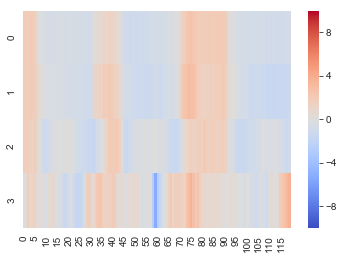

In [53]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
scaler.fit(df_tmp.iloc[:(600//10)//2])
X = scaler.transform(df_tmp)
sns.heatmap(X.transpose(), cmap='coolwarm', vmin=-10, vmax=10)
plt.show()

In [48]:


df = select_cond_neurons(n, ifr_all=ifr_all, cond='acute_sal')
total_sal = df.shape[1]
df = select_cond_neurons(n, ifr_all=ifr_all, cond='acute_cit')
total_cit = df.shape[1]

print(total_sal + total_cit)

0
